## [Mestrado] 8. Experimentos com autoencoder LSTM usando reais + demais 50% instâncias simuladas

### Carregamento e tratamento dos dados **simulados e reais** para experimentação:

In [1]:
# Artifício para alcular tempo total do notebook Jupyter
from datetime import datetime 
start_time = datetime.now()

In [2]:
# Experimentos para defesa de mestrado (autoencoder com lstm)
# Carregamento e tratamento dos dados simulados
%matplotlib inline
import pandas as pd
import numpy as np
import logging
import warnings
import tensorflow as tf
from math import ceil
from time import time
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import LocalOutlierFactor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam

warnings.simplefilter(action='ignore')

data_path = Path('./', 'data')
random_state = 1
np.random.seed(random_state)
tf.random.set_seed(random_state)
events_names = {0: 'Normal',
                1: 'Aumento Abrupto de BSW',
                2: 'Fechamento Espúrio de DHSV',
                3: 'Intermitência Severa',
                4: 'Instabilidade de Fluxo',
                5: 'Perda Rápida de Produtividade',
                6: 'Restrição Rápida em CKP',
                7: 'Incrustação em CKP',
                8: 'Hidrato em Linha de Produção'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class'] 
normal_class_code = 0
abnormal_classes_codes = [1, 2, 5, 6, 7, 8]
sample_size = 3*60              # Nas observações = segundos
min_normal_period_size = 20*60  # Nas observações = segundos
split_range = 0.6               # Porcentagem de separação entre treino/teste
max_samples_per_period = 15     # limitação por 'segurança'
max_nan_percent = 0.1           # Para seleção de variáveis úteis
std_vars_min = 0.01             # Para seleção de variáveis úteis
disable_progressbar = True      # Para menos saídas no notebook

def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    """Gerador de lista contendo número da classe e caminho do arquivo de acordo com a fonte da instância."""    
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path
                        
                    
def load_instance(instance_path):
    """Função que carrega cada instância individualmente"""
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, sep=',', header=0)
        assert (df.columns == columns).all(), \
            f'Colunas inválidas no arquivo {str(instance_path)}: {str(df.columns.tolist())}'
        return df
    except Exception as e:
        raise Exception(f'Erro ao ler arquivo {instance_path}: {e}')
        
def extract_samples(df, class_code):
    # Obtém os rótulos das observações e seu conjunto inequívoco
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))       
    
    # Descarta os rótulos das observações e substitui todos os nan por 0
    # (requisito da biblioteca tsfresh)
    df_vars = df.drop('class', axis=1).fillna(0)  
    
    # Inicializa objetos que serão retornados
    df_samples_train = pd.DataFrame()
    df_samples_test = pd.DataFrame()
    y_train = []
    y_test = []
            
    # Descubre o número máximo de amostras em períodos normais, transitórios e em regime
    # Obtém índices (primeiro e último) sem sobreposição com outros períodos
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

    # Define o número inicial de amostras para o período normal
    max_samples_normal = l_idx-f_idx+1-sample_size
    if (max_samples_normal) > 0:      
        num_normal_samples = min(max_samples_per_period, max_samples_normal)
        num_train_samples = int(split_range*num_normal_samples)
        num_test_samples = num_normal_samples - num_train_samples    
    else:
        num_train_samples = 0
        num_test_samples = 0
    
    # Define o número máximo de amostras por período transitório
    transient_code = class_code + 100    
    if transient_code in set_ols:
        # Obtém índices (primeiro e último) com possível sobreposição
        # no início do período
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code)        
        max_transient_samples = l_idx-f_idx+1-sample_size
    else:
        max_transient_samples = 0            

    # Define o número máximo de amostras no período de regime
    if class_code in set_ols:
        # Obtém índices (primeiro e último) com possível sobreposição 
        # no início ou fim do período
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1
        max_in_regime_samples = l_idx-f_idx+1-sample_size
    else:
        max_in_regime_samples = 0   
        
    # Descubre o número adequado de amostras em períodos normais, transitórios e em regime
    num_transient_samples = ceil(num_test_samples/2)
    num_in_regime_samples = num_test_samples - num_transient_samples
    if (max_transient_samples >= num_transient_samples) and \
       (max_in_regime_samples < num_in_regime_samples):
        num_in_regime_samples = max_in_regime_samples        
        num_transient_samples = min(num_test_samples-num_in_regime_samples, max_transient_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples >= num_in_regime_samples):
        num_transient_samples = max_transient_samples        
        num_in_regime_samples = min(num_test_samples-num_transient_samples, max_in_regime_samples)
    elif (max_transient_samples < num_transient_samples) and \
         (max_in_regime_samples < num_in_regime_samples):
        num_transient_samples = max_transient_samples
        num_in_regime_samples = max_in_regime_samples
        num_test_samples = num_transient_samples+num_in_regime_samples
    
    # Extrai amostras do período normal para treinamento e teste
    # Obtém índices (primeiro e último) sem sobreposição com outros períodos
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)
    
    # Define a etapa correta e extrai amostras
    if (num_normal_samples) > 0:  
        if num_normal_samples == max_samples_normal:
            step_max = 1 
        else:
            step_max = (max_samples_normal-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Extrai amostras para treinamento
        sample_id = 0
        for idx in range(num_train_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_train = df_samples_train.append(df_sample)
            y_train.append(normal_class_code)
            sample_id += 1
    
        # Extrai amostras para teste
        sample_id = 0
        for idx in range(num_train_samples, num_train_samples+num_test_samples):
            f_idx_c = l_idx-sample_size+1-(num_normal_samples-1-idx)*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(normal_class_code)
            sample_id += 1

    # Extrai amostras do período transitório (se existir) para teste
    if (num_transient_samples) > 0:    
        # Define a etapa correta e extrai amostras
        if num_transient_samples == max_transient_samples:
            step_max = 1 
        else:
            step_max = (max_transient_samples-1) // (max_samples_per_period-1)
        step_wanted = np.inf
        step = min(step_wanted, step_max)
        
        # Obtém índices (primeiro e último) com possível sobreposição no início deste período
        f_idx = ols.index(transient_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(transient_code) 

        # Extrai amostras
        for idx in range(num_transient_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(transient_code)
            sample_id += 1
            
    # Extrai amostras do período em regime (se existir) para teste
    if (num_in_regime_samples) > 0:     
        # Define a etapa correta e extrai amostras
        if num_in_regime_samples == max_in_regime_samples:
            step_max = 1 
        else:
            step_max = (max_in_regime_samples-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
        
        # Obtém índices (primeiro e último) com possível sobreposição 
        # no início ou no final deste período
        f_idx = ols.index(class_code)
        if f_idx-(sample_size-1) > 0:
            f_idx = f_idx-(sample_size-1)
        else:
            f_idx = 0
        l_idx = len(ols)-1-ols[::-1].index(class_code)
        if l_idx+(sample_size-1) < len(ols)-1:
            l_idx = l_idx+(sample_size-1) 
        else:
            l_idx = len(ols)-1

        # Extrai amostras
        for idx in range(num_in_regime_samples):
            f_idx_c = f_idx+idx*step
            l_idx_c = f_idx_c+sample_size
            df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
            df_sample.insert(loc=0, column='id', value=sample_id)
            df_samples_test = df_samples_test.append(df_sample)
            y_test.append(class_code)
            sample_id += 1

    return df_samples_train, y_train, df_samples_test, y_test

In [3]:
# Gets all simulated instances but maintains only those with any type of undesirable event
simulated_instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=False,
                                                       simulated=True, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
simulated_instances = simulated_instances.loc[simulated_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)

X_train_simuladas_unificado = pd.DataFrame()
y_train_simuladas_unificado = np.array([])
X_test_simuladas_unificado = pd.DataFrame()    
y_test_simuladas_unificado = np.array([])

# For each instance with any type of undesirable event
ignored_instances = 0
used_instances = 0

# Loop por todas as instâncias para capturar as observações
for i, row in simulated_instances.iterrows():
    # Loads the current instance
    class_code, instance_path = row
    #print(f'Instância {i+1}: {instance_path}')
    df = load_instance(instance_path)
    
    # Ignores instances without sufficient normal periods
    normal_period_size = (df['class']==float(normal_class_code)).sum()
    if normal_period_size < min_normal_period_size:
        ignored_instances += 1
        #print(f'\tignorado porque normal_period_size é insuficiente para treinamento ({normal_period_size})\n')
        continue
    used_instances += 1
        
    # Extracts samples from the current real instance
    ret = extract_samples(df, class_code)
    df_samples_train, y_train, df_samples_test, y_test = ret
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # As observações normais com label 1 e as anomalias com label -1
    y_train[y_train!=normal_class_code] = '-1'
    y_train[y_train==normal_class_code] = '1'
    y_test[y_test!=normal_class_code] = '-1'
    y_test[y_test==normal_class_code] = '1'
    
    """
    # Drops the bad vars
    good_vars = np.isnan(df_samples_train[vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_samples_train[vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_samples_train.drop(columns=bad_vars, inplace=True, errors='ignore')
    df_samples_test.drop(columns=bad_vars, inplace=True, errors='ignore')
    """
    
    # Normalizes the samples (zero mean and unit variance)
    scaler = preprocessing.StandardScaler()
    df_samples_train[vars] = scaler.fit_transform(df_samples_train[vars]).astype('float32')
    df_samples_test[vars] = scaler.transform(df_samples_test[vars]).astype('float32')
    
    # Remove a coluna timestamp (não é usada como entrada nos classificadores)
    df_samples_train = df_samples_train.drop('timestamp', 1)
    df_samples_test = df_samples_test.drop('timestamp', 1)
    
    # Rearranja o dataframe df_samples_train para que as variáveis estejam em linha
    df_samples_train_ajustado = (
        df_samples_train.pivot_table(values=None, 
                                     index='id', 
                                     columns=df_samples_train.groupby('id').cumcount() + 1, 
                                     aggfunc='first')
        .reset_index()
        )
    
    # Rearranja o dataframe df_samples_test para que as variáveis estejam em linha
    df_samples_test_ajustado = (
        df_samples_test.pivot_table(values=None, 
                                     index='id', 
                                     columns=df_samples_test.groupby('id').cumcount() + 1, 
                                     aggfunc='first')
        .reset_index()
        )
    
    X_train = df_samples_train_ajustado
    X_test = df_samples_test_ajustado
    
    # Agrupa as observacoes de cada instancia em dataframe unificado
    X_train_simuladas_unificado = X_train_simuladas_unificado.append(df_samples_train_ajustado)
    y_train_simuladas_unificado = np.concatenate((y_train_simuladas_unificado, y_train), axis=None)
    X_test_simuladas_unificado = X_test_simuladas_unificado.append(df_samples_test_ajustado)     
    y_test_simuladas_unificado = np.concatenate((y_test_simuladas_unificado, y_test), axis=None)
    

# Ajustes para completar valores faltantes com zero e remover os multiindexes criados
X_train_simuladas_unificado = X_train_simuladas_unificado.replace(np.nan, 0)
X_test_simuladas_unificado = X_test_simuladas_unificado.replace(np.nan, 0)

X_train_simuladas_unificado.drop('id',  axis='columns', inplace=True)
X_test_simuladas_unificado.drop('id',  axis='columns', inplace=True)

X_train_simuladas_unificado = X_train_simuladas_unificado.droplevel(0, axis=1)
X_test_simuladas_unificado = X_test_simuladas_unificado.droplevel(0, axis=1)

X_train_simuladas_unificado = X_train_simuladas_unificado.T.reset_index(drop=True).T
X_test_simuladas_unificado = X_test_simuladas_unificado.T.reset_index(drop=True).T

X_train_simuladas_unificado.reset_index(inplace=True, drop=True)
X_test_simuladas_unificado.reset_index(inplace=True, drop=True)

# Reshape dos dados para formato de entrada da rede LSTM
# que é um array 3D no formato (observações, timesteps, features)
X_train_simuladas_unificado = X_train_simuladas_unificado.values.reshape(X_train_simuladas_unificado.shape[0], 180, X_train_simuladas_unificado.shape[1] // 180, order='F')
X_test_simuladas_unificado = X_test_simuladas_unificado.values.reshape(X_test_simuladas_unificado.shape[0], 180, X_test_simuladas_unificado.shape[1] // 180, order='F')

# Shuffle no dataset para misturar as classes de anomalias
X_train_simuladas_unificado, y_train_simuladas_unificado = shuffle(X_train_simuladas_unificado, y_train_simuladas_unificado, random_state=random_state)
X_test_simuladas_unificado, y_test_simuladas_unificado = shuffle(X_test_simuladas_unificado, y_test_simuladas_unificado, random_state=random_state)

In [4]:
# Gets all real instances but maintains only those with any type of undesirable event
real_instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)


X_train_reais_unificado = pd.DataFrame()
y_train_reais_unificado = np.array([])
X_test_reais_unificado = pd.DataFrame()    
y_test_reais_unificado = np.array([])

# For each instance with any type of undesirable event
ignored_instances = 0
used_instances = 0

# Loop por todas as instâncias para capturar as observações
for i, row in real_instances.iterrows():
    # Loads the current instance
    class_code, instance_path = row
    #print(f'Instância {i+1}: {instance_path}')
    df = load_instance(instance_path)
    
    # Ignores instances without sufficient normal periods
    normal_period_size = (df['class']==float(normal_class_code)).sum()
    if normal_period_size < min_normal_period_size:
        ignored_instances += 1
        #print(f'\tignorado porque normal_period_size é insuficiente para treinamento ({normal_period_size})\n')
        continue
    used_instances += 1
        
    # Extracts samples from the current real instance
    ret = extract_samples(df, class_code)
    df_samples_train, y_train, df_samples_test, y_test = ret
    
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # As observações normais com label 1 e as anomalias com label -1
    y_train[y_train!=normal_class_code] = '-1'
    y_train[y_train==normal_class_code] = '1'
    y_test[y_test!=normal_class_code] = '-1'
    y_test[y_test==normal_class_code] = '1'
    
    """
    # Drops the bad vars
    good_vars = np.isnan(df_samples_train[vars]).mean(0) <= max_nan_percent
    std_vars = np.nanstd(df_samples_train[vars], 0)
    good_vars &= (std_vars > std_vars_min)    
    good_vars = list(good_vars.index[good_vars])
    bad_vars = list(set(vars)-set(good_vars))
    df_samples_train.drop(columns=bad_vars, inplace=True, errors='ignore')
    df_samples_test.drop(columns=bad_vars, inplace=True, errors='ignore')
    """
    # Normalizes the samples (zero mean and unit variance)
    scaler = preprocessing.StandardScaler()
    df_samples_train[vars] = scaler.fit_transform(df_samples_train[vars]).astype('float32')
    df_samples_test[vars] = scaler.transform(df_samples_test[vars]).astype('float32')
    
    # Remove a coluna timestamp (não é usada como entrada nos classificadores)
    df_samples_train = df_samples_train.drop('timestamp', 1)
    df_samples_test = df_samples_test.drop('timestamp', 1)
    
    # Rearranja o dataframe df_samples_train para que as variáveis estejam em linha
    df_samples_train_ajustado = (
        df_samples_train.pivot_table(values=None, 
                                     index='id', 
                                     columns=df_samples_train.groupby('id').cumcount() + 1, 
                                     aggfunc='first')
        .reset_index()
        )
    
    # Rearranja o dataframe df_samples_test para que as variáveis estejam em linha
    df_samples_test_ajustado = (
        df_samples_test.pivot_table(values=None, 
                                     index='id', 
                                     columns=df_samples_test.groupby('id').cumcount() + 1, 
                                     aggfunc='first')
        .reset_index()
        )
    
    X_train = df_samples_train_ajustado
    X_test = df_samples_test_ajustado
    
    # Agrupa as observacoes de cada instancia em dataframe unificado
    X_train_reais_unificado = X_train_reais_unificado.append(df_samples_train_ajustado)
    y_train_reais_unificado = np.concatenate((y_train_reais_unificado, y_train), axis=None)
    X_test_reais_unificado = X_test_reais_unificado.append(df_samples_test_ajustado)     
    y_test_reais_unificado = np.concatenate((y_test_reais_unificado, y_test), axis=None)
    

# Ajustes para completar valores faltantes com zero e remover os multiindexes criados
X_train_reais_unificado = X_train_reais_unificado.replace(np.nan, 0)
X_test_reais_unificado = X_test_reais_unificado.replace(np.nan, 0)

X_train_reais_unificado.drop('id',  axis='columns', inplace=True)
X_test_reais_unificado.drop('id',  axis='columns', inplace=True)

X_train_reais_unificado = X_train_reais_unificado.droplevel(0, axis=1)
X_test_reais_unificado = X_test_reais_unificado.droplevel(0, axis=1)

X_train_reais_unificado = X_train_reais_unificado.T.reset_index(drop=True).T
X_test_reais_unificado = X_test_reais_unificado.T.reset_index(drop=True).T

X_train_reais_unificado.reset_index(inplace=True, drop=True)
X_test_reais_unificado.reset_index(inplace=True, drop=True)

# Reshape dos dados para formato de entrada da rede LSTM
# que é um array 3D no formato (observações, timesteps, features)
X_train_reais_unificado = X_train_reais_unificado.values.reshape(X_train_reais_unificado.shape[0], 180, X_train_reais_unificado.shape[1] // 180, order='F')
X_test_reais_unificado = X_test_reais_unificado.values.reshape(X_test_reais_unificado.shape[0], 180, X_test_reais_unificado.shape[1] // 180, order='F')

# Shuffle no dataset para misturar as classes de anomalias
X_train_reais_unificado, y_train_reais_unificado = shuffle(X_train_reais_unificado, y_train_reais_unificado, random_state=random_state)
X_test_reais_unificado, y_test_reais_unificado = shuffle(X_test_reais_unificado, y_test_reais_unificado, random_state=random_state)

### Aplicação do classificador escolhido nas instâncias reais (somente)

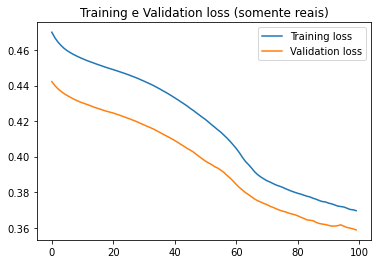

mean_trainMAE: 0.3649713099002838


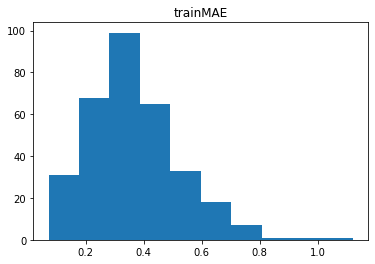

max_trainMAE: 	 1.1210131645202637


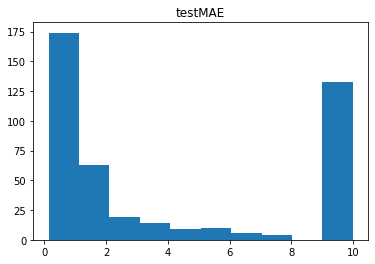


MEDIDA F1 Autoencoder (somente reais): 0.815


MEDIDA F1 LOF (somente reais): 0.500



In [5]:
# Simula a rede neural com melhores parâmetros com os dados reais (somente)
lstm_encoder = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train_reais_unificado.shape[1], X_train_reais_unificado.shape[2])),
    Dropout(rate=0),
    LSTM(16, return_sequences=False),
    Dropout(rate=0),
], name='encoder')
lstm_decoder = Sequential([
    RepeatVector(X_train_reais_unificado.shape[1]),
    LSTM(16, return_sequences=True),
    Dropout(rate=0),
    LSTM(32, return_sequences=True),
    Dropout(rate=0),
    TimeDistributed(Dense(X_train_reais_unificado.shape[2]))    
], name='decoder')
model_reais = Sequential([lstm_encoder, lstm_decoder])
model_reais.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')
history = model_reais.fit(X_train_reais_unificado, X_train_reais_unificado, epochs=100, batch_size=32, validation_split=0.4, verbose=0)


# Gráfico de train e validation loss
fig1, ax1 = plt.subplots()
ax1.set_title(f'Training e Validation loss (somente reais)')
ax1.plot(history.history['loss'], label=f'Training loss')
ax1.plot(history.history['val_loss'], label=f'Validation loss')
ax1.legend()
plt.show()

trainPredict = model_reais.predict(X_train_reais_unificado)
trainMAE = np.mean(np.mean(np.abs(trainPredict - X_train_reais_unificado), axis=1), axis=1)
mean_trainMAE = np.mean(trainMAE)
print(f'mean_trainMAE: {mean_trainMAE}')

fig2, ax2 = plt.subplots()
ax2.set_title(f'trainMAE')
ax2.hist(trainMAE)
plt.show()

max_trainMAE = np.max(trainMAE)
print(f'max_trainMAE: \t {max_trainMAE}')

testPredict = model_reais.predict(X_test_reais_unificado)
testMAE = np.mean(np.mean(np.abs(testPredict - X_test_reais_unificado), axis=1), axis=1)

fig3, ax3 = plt.subplots()
ax3.set_title(f'testMAE')
#Para o histograma, todos os valores maiores que 10 setei como 10 para melhor visualização
testMAE_visualizacao = testMAE
testMAE_visualizacao[testMAE_visualizacao > 10] = 10
ax3.hist(testMAE_visualizacao)
plt.show()

# Será considerada anomalia aquela observação cujo erro de reconstrução seja 
# acima de um valor especificado como gatilho (usado max_trainMAE)
y_pred = pd.DataFrame((testMAE >= max_trainMAE)).replace({True:-1,False:1})

# Calcula as metricas de desempenho
p, r, f1, _ = precision_recall_fscore_support(y_test_reais_unificado, y_pred, average='micro')
print(f'\nMEDIDA F1 Autoencoder (somente reais): {f1:.3f}\n')


# Testa o LOF nos melhores parametros calculados
encoder = model_reais.get_layer("encoder")
X_train_reais_unificado_encoded = encoder.predict(X_train_reais_unificado)
X_test_reais_unificado_encoded = encoder.predict(X_test_reais_unificado)

lof_clf_reais = LocalOutlierFactor(algorithm='auto', contamination='auto', 
                             metric='hamming', n_neighbors= 5, 
                             novelty= True)
lof_clf_reais.fit(X_train_reais_unificado_encoded)
y_pred = lof_clf_reais.predict(X_test_reais_unificado_encoded)
p, r, f1, _ = precision_recall_fscore_support(y_test_reais_unificado, y_pred, average='micro')
print(f'\nMEDIDA F1 LOF (somente reais): {f1:.3f}\n')

### Aplicação do classificador escolhido nas instâncias reais + demais simuladas (10%)

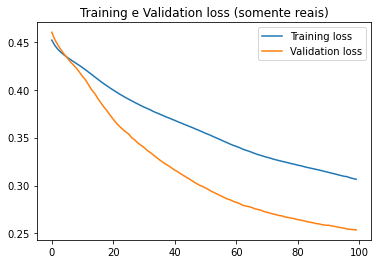

mean_trainMAE: 0.2849009335041046


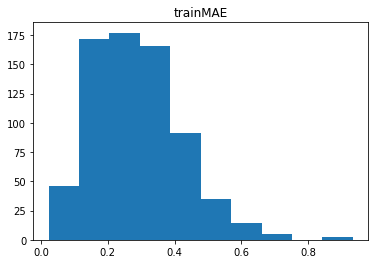

max_trainMAE: 	 0.9336584806442261


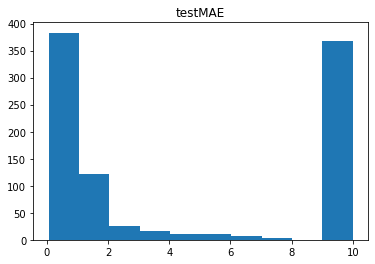


MEDIDA F1 Autoencoder (reais + 10% simuladas): 0.852


MEDIDA F1 LOF (reais + 10% simuladas): 0.499



In [6]:
# Concatena reais mais 10% das demais instâncias simuladas
X_train_reais_simuladas_10 = np.concatenate([X_train_reais_unificado, X_train_simuladas_unificado[ceil(0.5*len(X_train_simuladas_unificado)):ceil(0.6*len(X_train_simuladas_unificado)), :, :]])
X_test_reais_simuladas_10 = np.concatenate([X_test_reais_unificado, X_test_simuladas_unificado[ceil(0.5*len(X_test_simuladas_unificado)):ceil(0.6*len(X_test_simuladas_unificado)), :, :]])
y_train_reais_simuladas_10 = np.concatenate([y_train_reais_unificado, y_train_simuladas_unificado[ceil(0.5*len(y_train_simuladas_unificado)):ceil(0.6*len(y_train_simuladas_unificado))]])
y_test_reais_simuladas_10 = np.concatenate([y_test_reais_unificado, y_test_simuladas_unificado[ceil(0.5*len(y_test_simuladas_unificado)):ceil(0.6*len(y_test_simuladas_unificado))]])

lstm_encoder = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train_reais_simuladas_10.shape[1], X_train_reais_simuladas_10.shape[2])),
    Dropout(rate=0),
    LSTM(16, return_sequences=False),
    Dropout(rate=0),
], name='encoder')
lstm_decoder = Sequential([
    RepeatVector(X_train_reais_unificado.shape[1]),
    LSTM(16, return_sequences=True),
    Dropout(rate=0),
    LSTM(32, return_sequences=True),
    Dropout(rate=0),
    TimeDistributed(Dense(X_train_reais_simuladas_10.shape[2]))    
], name='decoder')
model_reais_simuladas_10 = Sequential([lstm_encoder, lstm_decoder])
model_reais_simuladas_10.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')
history_reais_simuladas_10 = model_reais_simuladas_10.fit(X_train_reais_simuladas_10, X_train_reais_simuladas_10, epochs=100, batch_size=32, validation_split=0.4, verbose=0)

# Gráfico de train e validation loss
fig1, ax1 = plt.subplots()
ax1.set_title(f'Training e Validation loss (somente reais)')
ax1.plot(history_reais_simuladas_10.history['loss'], label=f'Training loss')
ax1.plot(history_reais_simuladas_10.history['val_loss'], label=f'Validation loss')
ax1.legend()
plt.show()

trainPredict = model_reais_simuladas_10.predict(X_train_reais_simuladas_10)
trainMAE = np.mean(np.mean(np.abs(trainPredict - X_train_reais_simuladas_10), axis=1), axis=1)
mean_trainMAE = np.mean(trainMAE)
print(f'mean_trainMAE: {mean_trainMAE}')

fig2, ax2 = plt.subplots()
ax2.set_title(f'trainMAE')
ax2.hist(trainMAE)
plt.show()

max_trainMAE = np.max(trainMAE)
print(f'max_trainMAE: \t {max_trainMAE}')

testPredict = model_reais_simuladas_10.predict(X_test_reais_simuladas_10)
testMAE = np.mean(np.mean(np.abs(testPredict - X_test_reais_simuladas_10), axis=1), axis=1)

fig3, ax3 = plt.subplots()
ax3.set_title(f'testMAE')
#Para o histograma, todos os valores maiores que 10 setei como 10 para melhor visualização
testMAE_visualizacao = testMAE
testMAE_visualizacao[testMAE_visualizacao > 10] = 10
ax3.hist(testMAE_visualizacao)
plt.show()

# Será considerada anomalia aquela observação cujo erro de reconstrução seja 
# acima de um valor especificado como gatilho (usado max_trainMAE)
y_pred = pd.DataFrame((testMAE >= max_trainMAE)).replace({True:-1,False:1})

# Calcula as metricas de desempenho
p, r, f1, _ = precision_recall_fscore_support(y_test_reais_simuladas_10, y_pred, average='micro')
print(f'\nMEDIDA F1 Autoencoder (reais + 10% simuladas): {f1:.3f}\n')

# Testa o LOF nos melhores parametros calculados
encoder = model_reais_simuladas_10.get_layer("encoder")
X_train_reais_simuladas_10_encoded = encoder.predict(X_train_reais_simuladas_10)
X_test_reais_simuladas_10_encoded = encoder.predict(X_test_reais_simuladas_10)

lof_clf_reais_simuladas_10 = LocalOutlierFactor(algorithm='auto', contamination='auto', 
                             metric='hamming', n_neighbors= 5, 
                             novelty= True)
lof_clf_reais_simuladas_10.fit(X_train_reais_simuladas_10_encoded)
y_pred = lof_clf_reais_simuladas_10.predict(X_test_reais_simuladas_10_encoded)
p, r, f1, _ = precision_recall_fscore_support(y_test_reais_simuladas_10, y_pred, average='micro')
print(f'\nMEDIDA F1 LOF (reais + 10% simuladas): {f1:.3f}\n')

### Aplicação do classificador escolhido nas instâncias reais + demais simuladas (20%)

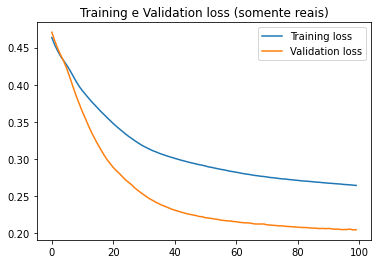

mean_trainMAE: 0.24004164338111877


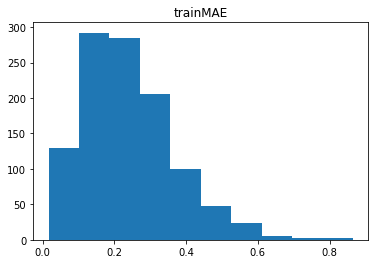

max_trainMAE: 	 0.8652259111404419


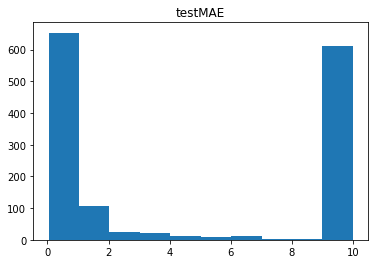


MEDIDA F1 Autoencoder (reais + 20% simuladas): 0.868


MEDIDA F1 LOF (reais + 20% simuladas): 0.495



In [7]:
# Concatena reais mais 20% das demais instâncias simuladas
X_train_reais_simuladas_20 = np.concatenate([X_train_reais_unificado, X_train_simuladas_unificado[ceil(0.5*len(X_train_simuladas_unificado)):ceil(0.7*len(X_train_simuladas_unificado)), :, :]])
X_test_reais_simuladas_20 = np.concatenate([X_test_reais_unificado, X_test_simuladas_unificado[ceil(0.5*len(X_test_simuladas_unificado)):ceil(0.7*len(X_test_simuladas_unificado)), :, :]])
y_train_reais_simuladas_20 = np.concatenate([y_train_reais_unificado, y_train_simuladas_unificado[ceil(0.5*len(y_train_simuladas_unificado)):ceil(0.7*len(y_train_simuladas_unificado))]])
y_test_reais_simuladas_20 = np.concatenate([y_test_reais_unificado, y_test_simuladas_unificado[ceil(0.5*len(y_test_simuladas_unificado)):ceil(0.7*len(y_test_simuladas_unificado))]])

lstm_encoder = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train_reais_simuladas_20.shape[1], X_train_reais_simuladas_20.shape[2])),
    Dropout(rate=0),
    LSTM(16, return_sequences=False),
    Dropout(rate=0),
], name='encoder')
lstm_decoder = Sequential([
    RepeatVector(X_train_reais_unificado.shape[1]),
    LSTM(16, return_sequences=True),
    Dropout(rate=0),
    LSTM(32, return_sequences=True),
    Dropout(rate=0),
    TimeDistributed(Dense(X_train_reais_simuladas_20.shape[2]))    
], name='decoder')
model_reais_simuladas_20 = Sequential([lstm_encoder, lstm_decoder])
model_reais_simuladas_20.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')
history_reais_simuladas_20 = model_reais_simuladas_20.fit(X_train_reais_simuladas_20, X_train_reais_simuladas_20, epochs=100, batch_size=32, validation_split=0.4, verbose=0)

# Gráfico de train e validation loss
fig1, ax1 = plt.subplots()
ax1.set_title(f'Training e Validation loss (somente reais)')
ax1.plot(history_reais_simuladas_20.history['loss'], label=f'Training loss')
ax1.plot(history_reais_simuladas_20.history['val_loss'], label=f'Validation loss')
ax1.legend()
plt.show()

trainPredict = model_reais_simuladas_20.predict(X_train_reais_simuladas_20)
trainMAE = np.mean(np.mean(np.abs(trainPredict - X_train_reais_simuladas_20), axis=1), axis=1)
mean_trainMAE = np.mean(trainMAE)
print(f'mean_trainMAE: {mean_trainMAE}')

fig2, ax2 = plt.subplots()
ax2.set_title(f'trainMAE')
ax2.hist(trainMAE)
plt.show()

max_trainMAE = np.max(trainMAE)
print(f'max_trainMAE: \t {max_trainMAE}')

testPredict = model_reais_simuladas_20.predict(X_test_reais_simuladas_20)
testMAE = np.mean(np.mean(np.abs(testPredict - X_test_reais_simuladas_20), axis=1), axis=1)

fig3, ax3 = plt.subplots()
ax3.set_title(f'testMAE')
#Para o histograma, todos os valores maiores que 10 setei como 10 para melhor visualização
testMAE_visualizacao = testMAE
testMAE_visualizacao[testMAE_visualizacao > 10] = 10
ax3.hist(testMAE_visualizacao)
plt.show()

# Será considerada anomalia aquela observação cujo erro de reconstrução seja 
# acima de um valor especificado como gatilho (usado max_trainMAE)
y_pred = pd.DataFrame((testMAE >= max_trainMAE)).replace({True:-1,False:1})

# Calcula as metricas de desempenho
p, r, f1, _ = precision_recall_fscore_support(y_test_reais_simuladas_20, y_pred, average='micro')
print(f'\nMEDIDA F1 Autoencoder (reais + 20% simuladas): {f1:.3f}\n')

# Testa o LOF nos melhores parametros calculados
encoder = model_reais_simuladas_20.get_layer("encoder")
X_train_reais_simuladas_20_encoded = encoder.predict(X_train_reais_simuladas_20)
X_test_reais_simuladas_20_encoded = encoder.predict(X_test_reais_simuladas_20)

lof_clf_reais_simuladas_20 = LocalOutlierFactor(algorithm='auto', contamination='auto', 
                             metric='hamming', n_neighbors= 5, 
                             novelty= True)
lof_clf_reais_simuladas_20.fit(X_train_reais_simuladas_20_encoded)
y_pred = lof_clf_reais_simuladas_20.predict(X_test_reais_simuladas_20_encoded)
p, r, f1, _ = precision_recall_fscore_support(y_test_reais_simuladas_20, y_pred, average='micro')
print(f'\nMEDIDA F1 LOF (reais + 20% simuladas): {f1:.3f}\n')

### Aplicação do classificador escolhido nas instâncias reais + demais simuladas (30%)

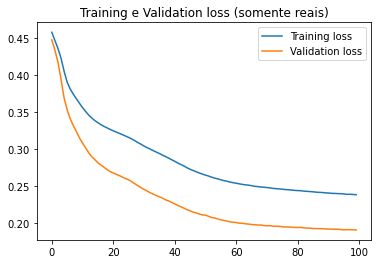

mean_trainMAE: 0.2186453938484192


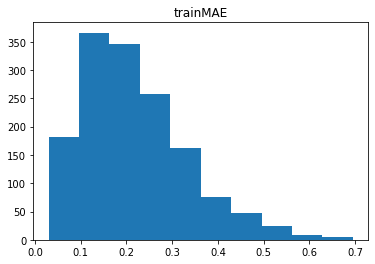

max_trainMAE: 	 0.6951549649238586


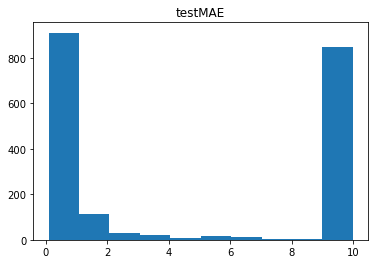


MEDIDA F1 Autoencoder (reais + 30% simuladas): 0.836


MEDIDA F1 LOF (reais + 30% simuladas): 0.499



In [8]:
# Concatena reais mais 30% das demais instâncias simuladas
X_train_reais_simuladas_30 = np.concatenate([X_train_reais_unificado, X_train_simuladas_unificado[ceil(0.5*len(X_train_simuladas_unificado)):ceil(0.8*len(X_train_simuladas_unificado)), :, :]])
X_test_reais_simuladas_30 = np.concatenate([X_test_reais_unificado, X_test_simuladas_unificado[ceil(0.5*len(X_test_simuladas_unificado)):ceil(0.8*len(X_test_simuladas_unificado)), :, :]])
y_train_reais_simuladas_30 = np.concatenate([y_train_reais_unificado, y_train_simuladas_unificado[ceil(0.5*len(y_train_simuladas_unificado)):ceil(0.8*len(y_train_simuladas_unificado))]])
y_test_reais_simuladas_30 = np.concatenate([y_test_reais_unificado, y_test_simuladas_unificado[ceil(0.5*len(y_test_simuladas_unificado)):ceil(0.8*len(y_test_simuladas_unificado))]])

lstm_encoder = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train_reais_simuladas_30.shape[1], X_train_reais_simuladas_30.shape[2])),
    Dropout(rate=0),
    LSTM(16, return_sequences=False),
    Dropout(rate=0),
], name='encoder')
lstm_decoder = Sequential([
    RepeatVector(X_train_reais_unificado.shape[1]),
    LSTM(16, return_sequences=True),
    Dropout(rate=0),
    LSTM(32, return_sequences=True),
    Dropout(rate=0),
    TimeDistributed(Dense(X_train_reais_simuladas_30.shape[2]))    
], name='decoder')
model_reais_simuladas_30 = Sequential([lstm_encoder, lstm_decoder])
model_reais_simuladas_30.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')
history_reais_simuladas_30 = model_reais_simuladas_30.fit(X_train_reais_simuladas_30, X_train_reais_simuladas_30, epochs=100, batch_size=32, validation_split=0.4, verbose=0)

# Gráfico de train e validation loss
fig1, ax1 = plt.subplots()
ax1.set_title(f'Training e Validation loss (somente reais)')
ax1.plot(history_reais_simuladas_30.history['loss'], label=f'Training loss')
ax1.plot(history_reais_simuladas_30.history['val_loss'], label=f'Validation loss')
ax1.legend()
plt.show()

trainPredict = model_reais_simuladas_30.predict(X_train_reais_simuladas_30)
trainMAE = np.mean(np.mean(np.abs(trainPredict - X_train_reais_simuladas_30), axis=1), axis=1)
mean_trainMAE = np.mean(trainMAE)
print(f'mean_trainMAE: {mean_trainMAE}')

fig2, ax2 = plt.subplots()
ax2.set_title(f'trainMAE')
ax2.hist(trainMAE)
plt.show()

max_trainMAE = np.max(trainMAE)
print(f'max_trainMAE: \t {max_trainMAE}')

testPredict = model_reais_simuladas_30.predict(X_test_reais_simuladas_30)
testMAE = np.mean(np.mean(np.abs(testPredict - X_test_reais_simuladas_30), axis=1), axis=1)

fig3, ax3 = plt.subplots()
ax3.set_title(f'testMAE')
#Para o histograma, todos os valores maiores que 10 setei como 10 para melhor visualização
testMAE_visualizacao = testMAE
testMAE_visualizacao[testMAE_visualizacao > 10] = 10
ax3.hist(testMAE_visualizacao)
plt.show()

# Será considerada anomalia aquela observação cujo erro de reconstrução seja 
# acima de um valor especificado como gatilho (usado max_trainMAE)
y_pred = pd.DataFrame((testMAE >= max_trainMAE)).replace({True:-1,False:1})

# Calcula as metricas de desempenho
p, r, f1, _ = precision_recall_fscore_support(y_test_reais_simuladas_30, y_pred, average='micro')
print(f'\nMEDIDA F1 Autoencoder (reais + 30% simuladas): {f1:.3f}\n')

# Testa o LOF nos melhores parametros calculados
encoder = model_reais_simuladas_30.get_layer("encoder")
X_train_reais_simuladas_30_encoded = encoder.predict(X_train_reais_simuladas_30)
X_test_reais_simuladas_30_encoded = encoder.predict(X_test_reais_simuladas_30)

lof_clf_reais_simuladas_30 = LocalOutlierFactor(algorithm='auto', contamination='auto', 
                             metric='hamming', n_neighbors= 5, 
                             novelty= True)
lof_clf_reais_simuladas_30.fit(X_train_reais_simuladas_30_encoded)
y_pred = lof_clf_reais_simuladas_30.predict(X_test_reais_simuladas_30_encoded)
p, r, f1, _ = precision_recall_fscore_support(y_test_reais_simuladas_30, y_pred, average='micro')
print(f'\nMEDIDA F1 LOF (reais + 30% simuladas): {f1:.3f}\n')

### Aplicação do classificador escolhido nas instâncias reais + demais simuladas (40%)

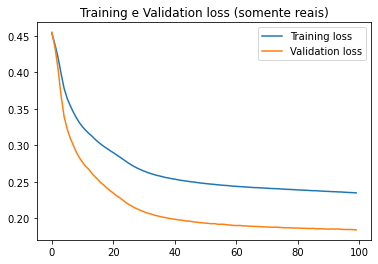

mean_trainMAE: 0.21429501473903656


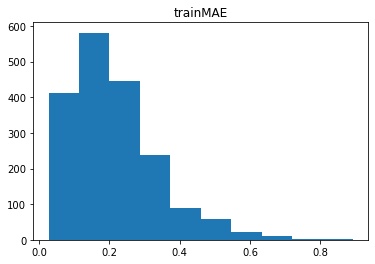

max_trainMAE: 	 0.8927129507064819


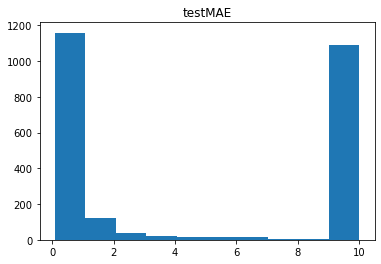


MEDIDA F1 Autoencoder (reais + 40% simuladas): 0.890


MEDIDA F1 LOF (reais + 40% simuladas): 0.497



In [9]:
# Concatena reais mais 40% das demais instâncias simuladas
X_train_reais_simuladas_40 = np.concatenate([X_train_reais_unificado, X_train_simuladas_unificado[ceil(0.5*len(X_train_simuladas_unificado)):ceil(0.9*len(X_train_simuladas_unificado)), :, :]])
X_test_reais_simuladas_40 = np.concatenate([X_test_reais_unificado, X_test_simuladas_unificado[ceil(0.5*len(X_test_simuladas_unificado)):ceil(0.9*len(X_test_simuladas_unificado)), :, :]])
y_train_reais_simuladas_40 = np.concatenate([y_train_reais_unificado, y_train_simuladas_unificado[ceil(0.5*len(y_train_simuladas_unificado)):ceil(0.9*len(y_train_simuladas_unificado))]])
y_test_reais_simuladas_40 = np.concatenate([y_test_reais_unificado, y_test_simuladas_unificado[ceil(0.5*len(y_test_simuladas_unificado)):ceil(0.9*len(y_test_simuladas_unificado))]])

lstm_encoder = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train_reais_simuladas_40.shape[1], X_train_reais_simuladas_40.shape[2])),
    Dropout(rate=0),
    LSTM(16, return_sequences=False),
    Dropout(rate=0),
], name='encoder')
lstm_decoder = Sequential([
    RepeatVector(X_train_reais_unificado.shape[1]),
    LSTM(16, return_sequences=True),
    Dropout(rate=0),
    LSTM(32, return_sequences=True),
    Dropout(rate=0),
    TimeDistributed(Dense(X_train_reais_simuladas_40.shape[2]))    
], name='decoder')
model_reais_simuladas_40 = Sequential([lstm_encoder, lstm_decoder])
model_reais_simuladas_40.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')
history_reais_simuladas_40 = model_reais_simuladas_40.fit(X_train_reais_simuladas_40, X_train_reais_simuladas_40, epochs=100, batch_size=32, validation_split=0.4, verbose=0)

# Gráfico de train e validation loss
fig1, ax1 = plt.subplots()
ax1.set_title(f'Training e Validation loss (somente reais)')
ax1.plot(history_reais_simuladas_40.history['loss'], label=f'Training loss')
ax1.plot(history_reais_simuladas_40.history['val_loss'], label=f'Validation loss')
ax1.legend()
plt.show()

trainPredict = model_reais_simuladas_40.predict(X_train_reais_simuladas_40)
trainMAE = np.mean(np.mean(np.abs(trainPredict - X_train_reais_simuladas_40), axis=1), axis=1)
mean_trainMAE = np.mean(trainMAE)
print(f'mean_trainMAE: {mean_trainMAE}')

fig2, ax2 = plt.subplots()
ax2.set_title(f'trainMAE')
ax2.hist(trainMAE)
plt.show()

max_trainMAE = np.max(trainMAE)
print(f'max_trainMAE: \t {max_trainMAE}')

testPredict = model_reais_simuladas_40.predict(X_test_reais_simuladas_40)
testMAE = np.mean(np.mean(np.abs(testPredict - X_test_reais_simuladas_40), axis=1), axis=1)

fig3, ax3 = plt.subplots()
ax3.set_title(f'testMAE')
#Para o histograma, todos os valores maiores que 10 setei como 10 para melhor visualização
testMAE_visualizacao = testMAE
testMAE_visualizacao[testMAE_visualizacao > 10] = 10
ax3.hist(testMAE_visualizacao)
plt.show()

# Será considerada anomalia aquela observação cujo erro de reconstrução seja 
# acima de um valor especificado como gatilho (usado max_trainMAE)
y_pred = pd.DataFrame((testMAE >= max_trainMAE)).replace({True:-1,False:1})

# Calcula as metricas de desempenho
p, r, f1, _ = precision_recall_fscore_support(y_test_reais_simuladas_40, y_pred, average='micro')
print(f'\nMEDIDA F1 Autoencoder (reais + 40% simuladas): {f1:.3f}\n')

# Testa o LOF nos melhores parametros calculados
encoder = model_reais_simuladas_40.get_layer("encoder")
X_train_reais_simuladas_40_encoded = encoder.predict(X_train_reais_simuladas_40)
X_test_reais_simuladas_40_encoded = encoder.predict(X_test_reais_simuladas_40)

lof_clf_reais_simuladas_40 = LocalOutlierFactor(algorithm='auto', contamination='auto', 
                             metric='hamming', n_neighbors= 5, 
                             novelty= True)
lof_clf_reais_simuladas_40.fit(X_train_reais_simuladas_40_encoded)
y_pred = lof_clf_reais_simuladas_40.predict(X_test_reais_simuladas_40_encoded)
p, r, f1, _ = precision_recall_fscore_support(y_test_reais_simuladas_40, y_pred, average='micro')
print(f'\nMEDIDA F1 LOF (reais + 40% simuladas): {f1:.3f}\n')

### Aplicação do classificador escolhido nas instâncias reais + demais simuladas (50%)

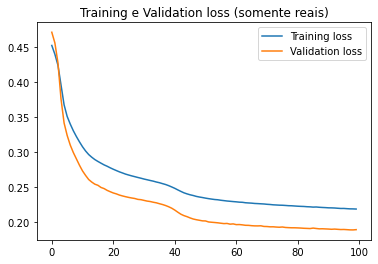

mean_trainMAE: 0.20623373985290527


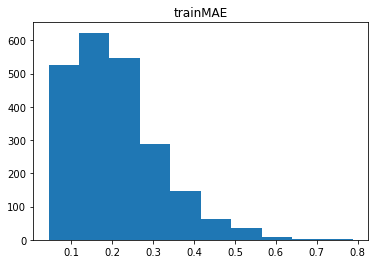

max_trainMAE: 	 0.7887290120124817


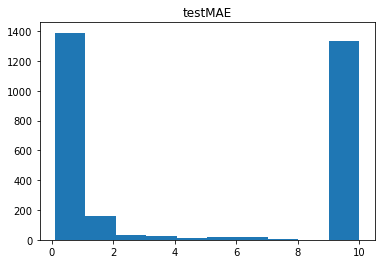


MEDIDA F1 Autoencoder (reais + 50% simuladas): 0.866


MEDIDA F1 LOF (reais + 50% simuladas): 0.493



In [10]:
# Concatena reais mais 50% das demais instâncias simuladas
X_train_reais_simuladas_50 = np.concatenate([X_train_reais_unificado, X_train_simuladas_unificado[ceil(0.5*len(X_train_simuladas_unificado)):ceil(1.0*len(X_train_simuladas_unificado)), :, :]])
X_test_reais_simuladas_50 = np.concatenate([X_test_reais_unificado, X_test_simuladas_unificado[ceil(0.5*len(X_test_simuladas_unificado)):ceil(1.0*len(X_test_simuladas_unificado)), :, :]])
y_train_reais_simuladas_50 = np.concatenate([y_train_reais_unificado, y_train_simuladas_unificado[ceil(0.5*len(y_train_simuladas_unificado)):ceil(1.0*len(y_train_simuladas_unificado))]])
y_test_reais_simuladas_50 = np.concatenate([y_test_reais_unificado, y_test_simuladas_unificado[ceil(0.5*len(y_test_simuladas_unificado)):ceil(1.0*len(y_test_simuladas_unificado))]])

lstm_encoder = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train_reais_simuladas_50.shape[1], X_train_reais_simuladas_50.shape[2])),
    Dropout(rate=0),
    LSTM(16, return_sequences=False),
    Dropout(rate=0),
], name='encoder')
lstm_decoder = Sequential([
    RepeatVector(X_train_reais_unificado.shape[1]),
    LSTM(16, return_sequences=True),
    Dropout(rate=0),
    LSTM(32, return_sequences=True),
    Dropout(rate=0),
    TimeDistributed(Dense(X_train_reais_simuladas_50.shape[2]))    
], name='decoder')
model_reais_simuladas_50 = Sequential([lstm_encoder, lstm_decoder])
model_reais_simuladas_50.compile(optimizer=Adam(learning_rate=0.0001), loss='mae')
history_reais_simuladas_50 = model_reais_simuladas_50.fit(X_train_reais_simuladas_50, X_train_reais_simuladas_50, epochs=100, batch_size=32, validation_split=0.4, verbose=0)

# Gráfico de train e validation loss
fig1, ax1 = plt.subplots()
ax1.set_title(f'Training e Validation loss (somente reais)')
ax1.plot(history_reais_simuladas_50.history['loss'], label=f'Training loss')
ax1.plot(history_reais_simuladas_50.history['val_loss'], label=f'Validation loss')
ax1.legend()
plt.show()

trainPredict = model_reais_simuladas_50.predict(X_train_reais_simuladas_50)
trainMAE = np.mean(np.mean(np.abs(trainPredict - X_train_reais_simuladas_50), axis=1), axis=1)
mean_trainMAE = np.mean(trainMAE)
print(f'mean_trainMAE: {mean_trainMAE}')

fig2, ax2 = plt.subplots()
ax2.set_title(f'trainMAE')
ax2.hist(trainMAE)
plt.show()

max_trainMAE = np.max(trainMAE)
print(f'max_trainMAE: \t {max_trainMAE}')

testPredict = model_reais_simuladas_50.predict(X_test_reais_simuladas_50)
testMAE = np.mean(np.mean(np.abs(testPredict - X_test_reais_simuladas_50), axis=1), axis=1)

fig3, ax3 = plt.subplots()
ax3.set_title(f'testMAE')
#Para o histograma, todos os valores maiores que 10 setei como 10 para melhor visualização
testMAE_visualizacao = testMAE
testMAE_visualizacao[testMAE_visualizacao > 10] = 10
ax3.hist(testMAE_visualizacao)
plt.show()

# Será considerada anomalia aquela observação cujo erro de reconstrução seja 
# acima de um valor especificado como gatilho (usado max_trainMAE)
y_pred = pd.DataFrame((testMAE >= max_trainMAE)).replace({True:-1,False:1})

# Calcula as metricas de desempenho
p, r, f1, _ = precision_recall_fscore_support(y_test_reais_simuladas_50, y_pred, average='micro')
print(f'\nMEDIDA F1 Autoencoder (reais + 50% simuladas): {f1:.3f}\n')

# Testa o LOF nos melhores parametros calculados
encoder = model_reais_simuladas_50.get_layer("encoder")
X_train_reais_simuladas_50_encoded = encoder.predict(X_train_reais_simuladas_50)
X_test_reais_simuladas_50_encoded = encoder.predict(X_test_reais_simuladas_50)

lof_clf_reais_simuladas_50 = LocalOutlierFactor(algorithm='auto', contamination='auto', 
                             metric='hamming', n_neighbors= 5, 
                             novelty= True)
lof_clf_reais_simuladas_50.fit(X_train_reais_simuladas_50_encoded)
y_pred = lof_clf_reais_simuladas_50.predict(X_test_reais_simuladas_50_encoded)
p, r, f1, _ = precision_recall_fscore_support(y_test_reais_simuladas_50, y_pred, average='micro')
print(f'\nMEDIDA F1 LOF (reais + 50% simuladas): {f1:.3f}\n')

In [11]:
# Calcular tempo total do notebook Jupyter
print(f'Tempo total de execução (hh:mm:ss.ms): {datetime.now() - start_time}')

Tempo total de execução (hh:mm:ss.ms): 0:42:28.832859
